In [2]:
import pandas as pd
import gurobipy 
from gurobipy import Model, GRB, quicksum
import numpy as np

#Loading the dataset 
brick_index_value = pd.read_csv('./bricks_index_values.csv')
brick_rp_distances = pd.read_csv('./brick_rp_distances.csv')

# STEP 1

### 1. Objectif de minimisation de la distance

In [3]:
#Extracting data from the datasets
bricks = brick_index_value['brick'].tolist()
reps = list(range(1, 5))  # 4 représentants

#Converting distance to a dictionary f
distances = {
    row['brick']: [row[f'rp{i}'] for i in reps]
    for _, row in brick_rp_distances.iterrows()
}
#Converting index values to a dictionary
index_values = dict(zip(brick_index_value['brick'], brick_index_value['index_value']))

#Workload interval bounds
L = 0.8 
U = 1.2

#Modèle pour minimiser la distance
model_distance = Model("Minimize_Distance")

#Variables de décision 
#Variables binaires x[b, r], chaques briques b est assignée à un représentant r
x = model_distance.addVars(bricks, reps, vtype=GRB.BINARY, name="x") 

#Fonction objectif : minimiser la distance totale
model_distance.setObjective(
    quicksum(distances[b][r - 1] * x[b, r] for b in bricks for r in reps), GRB.MINIMIZE
)

#Chaque brique est assignée à un seul représentant
model_distance.addConstrs(
    (quicksum(x[b, r] for r in reps) == 1 for b in bricks), name="AssignEachBrick"
)

#Contraintes de charge de travail dans l'intervalle [L, U]
model_distance.addConstrs(
    (quicksum(index_values[b] * x[b, r] for b in bricks) >= L for r in reps), name="MinWorkload"
)

model_distance.addConstrs(
    (quicksum(index_values[b] * x[b, r] for b in bricks) <= U for r in reps), name="MaxWorkload"
)

#Optimisation
model_distance.optimize()

Set parameter Username
Set parameter LicenseID to value 2600216
Academic license - for non-commercial use only - expires 2025-12-17
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 23.6.0 23G80)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 30 rows, 88 columns and 264 nonzeros
Model fingerprint: 0x4ea169f8
Variable types: 0 continuous, 88 integer (88 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  Objective range  [8e-01, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]
Found heuristic solution: objective 353.0700000
Presolve time: 0.00s
Presolved: 30 rows, 88 columns, 264 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)

Root relaxation: objective 1.488198e+02, 25 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd

In [4]:
# Affichage des résultats sous forme de tableau
if model_distance.Status == GRB.OPTIMAL:
    print("\nDistance totale minimale :", model_distance.ObjVal)
    results = []
    for b in bricks:
        for r in reps:
            if x[b, r].X > 0.5:
                results.append([b, r])

    # Création du DataFrame pour afficher les résultats
    results_df = pd.DataFrame(
        results, columns=['Brick', 'Représentant'])

results_df[['Brick', 'Représentant']]



Distance totale minimale : 154.62


,Brick,Représentant
0,1,4
1,2,4
2,3,4
3,4,1
4,5,1
5,6,1
6,7,1
7,8,1
8,9,1
9,10,3


### 2. Objectif minimisation de disruption

In [5]:
#Assignation initiale des briques aux représentants
initial_assignment = {
    4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 15: 1,   # SR 1
    10: 2, 11: 2, 12: 2, 13: 2, 14: 2,     # SR 2
    9: 3, 16: 3, 17: 3, 18: 3,             # SR 3
    1: 4, 2: 4, 3: 4, 19: 4, 20: 4, 21: 4, 22: 4  # SR 4
}

#Modèle pour minimiser la perturbation
model_disruption = Model("Minimize_Disruption")

#Variables de décision
x = model_disruption.addVars(bricks, reps, vtype=GRB.BINARY, name="x")
y = model_disruption.addVars(bricks, reps, vtype=GRB.BINARY, name="y")

#Fonction objectif : minimiser la perturbation pondérée par l'index
model_disruption.setObjective(
    quicksum(index_values[b] * y[b, r] for b in bricks for r in reps), GRB.MINIMIZE
)

#Contraintes
#Chaque brick doit être attribué à un seul représentant
model_disruption.addConstrs(
    (quicksum(x[b, r] for r in reps) == 1 for b in bricks), name="AssignEachBrick"
)

#Charge de travail dans l'intervalle [L, U]
model_disruption.addConstrs(
    (quicksum(index_values[b] * x[b, r] for b in bricks) >= L for r in reps), name="MinWorkload"
)
model_disruption.addConstrs(
    (quicksum(index_values[b] * x[b, r] for b in bricks) <= U for r in reps), name="MaxWorkload"
)

#Mesurer la perturbation
model_disruption.addConstrs(
    (y[b, r] >= x[b, r] - (1 if initial_assignment[b] == r else 0)
     for b in bricks for r in reps), name="Disruption"
)

#Résoudre le modèle
model_disruption.optimize()

Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 23.6.0 23G80)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 118 rows, 176 columns and 440 nonzeros
Model fingerprint: 0xa736d90c
Variable types: 0 continuous, 176 integer (176 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  Objective range  [4e-02, 8e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]
Found heuristic solution: objective 2.6088000
Presolve removed 88 rows and 88 columns
Presolve time: 0.00s
Presolved: 30 rows, 88 columns, 264 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)

Root relaxation: objective 1.377000e-01, 25 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.13770    0    4    2.60880    0.13770  94.7%     

In [6]:
# Afficher les résultats sous forme de tableau
if model_disruption.Status == GRB.OPTIMAL:
    print("\nPerturbation totale minimale :", model_disruption.ObjVal)
    results = []
    for b in bricks:
        for r in reps:
            if x[b, r].X > 0.5:
                results.append([b, r])

    # Création du DataFrame pour afficher les résultats
    results_df = pd.DataFrame(results, columns=['Brick', 'Représentant'])

results_df[['Brick', 'Représentant']]


Perturbation totale minimale : 0.1696


,Brick,Représentant
0,1,4
1,2,4
2,3,4
3,4,1
4,5,1
5,6,1
6,7,1
7,8,1
8,9,3
9,10,2


### Epsilon Constraints

In [7]:
import matplotlib.pyplot as plt
import numpy as np

#Workload bounds to test
workload_bounds = [(0.8, 1.2), (0.85, 1.15), (0.9, 1.1)]

from gurobipy import Model, GRB, quicksum
import numpy as np

import numpy as np
from gurobipy import Model, GRB, quicksum

def extract_solution(model, bricks, reps):
    """Extrait la solution optimale du modèle Gurobi."""
    return np.array([[model.getVarByName(f"assignments[{s},{b}]").x for b in bricks] for s in reps])

def epsilon_constraint_scheme(assignment_matrix: np.ndarray, distances_matrix: np.ndarray, workload_matrix: np.ndarray, workload_bounds):
    pareto_solutions = []
    
    nb_srs, nb_bricks = assignment_matrix.shape
    reps = list(range(nb_srs))
    bricks = list(range(nb_bricks))

    for L, U in workload_bounds:
        print(f"\nSolving for workload constraints: [{L}, {U}]")

        # Modèle initial pour obtenir le max de disruption (sans contrainte sur epsilon)
        model_init = Model("Initial_Solution")
        new_assignment = model_init.addVars(reps, bricks, vtype=GRB.BINARY, name="assignments")

        total_disruption = quicksum(workload_matrix[b] * (new_assignment[s, b] - assignment_matrix[s, b])**2 for s in reps for b in bricks)
        total_distance = quicksum(distances_matrix[s, b] * new_assignment[s, b] for s in reps for b in bricks)

        model_init.addConstrs((quicksum(new_assignment[s, b] for s in reps) == 1 for b in bricks), name="AssignEachBrick")
        model_init.addConstrs((quicksum(new_assignment[s, b] * workload_matrix[b] for b in bricks) >= L for s in reps), name="MinWorkload")
        model_init.addConstrs((quicksum(new_assignment[s, b] * workload_matrix[b] for b in bricks) <= U for s in reps), name="MaxWorkload")

        model_init.setObjective(total_disruption, GRB.MAXIMIZE)  # Maximiser disruption pour avoir epsilon initial
        model_init.optimize()

        if model_init.Status != GRB.OPTIMAL:
            print(f"Aucune solution initiale trouvée pour [{L}, {U}]")
            continue

        epsilon = total_disruption.getValue()  # Initialisation de epsilon

        # Boucle epsilon-constraint
        while epsilon >= 0:
            model = Model("Epsilon_Constraint")
            new_assignment = model.addVars(reps, bricks, vtype=GRB.BINARY, name="assignments")

            total_disruption = quicksum(workload_matrix[b] * (new_assignment[s, b] - assignment_matrix[s, b])**2 for s in reps for b in bricks)
            total_distance = quicksum(distances_matrix[s, b] * new_assignment[s, b] for s in reps for b in bricks)

            # Contraintes
            model.addConstrs((quicksum(new_assignment[s, b] for s in reps) == 1 for b in bricks), name="AssignEachBrick")
            model.addConstrs((quicksum(new_assignment[s, b] * workload_matrix[b] for b in bricks) >= L for s in reps), name="MinWorkload")
            model.addConstrs((quicksum(new_assignment[s, b] * workload_matrix[b] for b in bricks) <= U for s in reps), name="MaxWorkload")
            model.addConstr(total_disruption <= epsilon, name="Epsilon_Distance")

            model.setObjective(total_distance, GRB.MINIMIZE)

            model.optimize()

            if model.Status == GRB.OPTIMAL:
                solution_distance = total_distance.getValue()
                solution_disruption = total_disruption.getValue()
                assignment = extract_solution(model, bricks, reps)
                pareto_solutions.append((L, U, solution_distance, solution_disruption, assignment))
                print(f"Solution found: Distance = {solution_distance}, Disruption = {solution_disruption}")
            else:
                print(f"No feasible solution for epsilon: {epsilon} and workload [{L}, {U}]")

            # Réduction de epsilon
            epsilon -= 0.1

    return pareto_solutions

### Instance 4 SRs 22 briques


Solving for workload constraints: [0.8, 1.2]
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 23.6.0 23G80)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 30 rows, 88 columns and 264 nonzeros
Model fingerprint: 0xf74d434f
Model has 88 quadratic objective terms
Variable types: 0 continuous, 88 integer (88 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+00]
  Objective range  [9e-02, 2e+00]
  QObjective range [9e-02, 2e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]
Found heuristic solution: objective 5.2176000
Presolve time: 0.00s
Presolved: 30 rows, 88 columns, 264 nonzeros
Variable types: 0 continuous, 88 integer (88 binary)

Root relaxation: objective 8.000000e+00, 38 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Nod

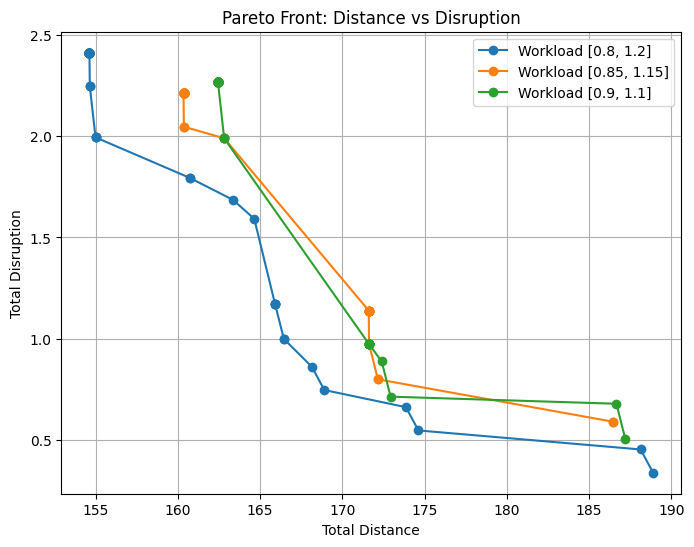

In [ ]:
num_sr = 4
num_bricks = 22

# Initialisation d'une matrice de zéros
assignment_matrix = np.zeros((num_sr, num_bricks), dtype=int)
# Remplissage de la matrice en fonction de l'affectation initiale
for brick, sr in initial_assignment.items():
    assignment_matrix[sr - 1, brick - 1] = 1  # Décalage d'indice (Python commence à 0)

#Matrices workload
workload = pd.read_csv(r"./bricks_index_values.csv")
workload.drop(columns = ['brick'], inplace=True)
workload_matrix = workload.to_numpy().T.flatten()

#Matrice distances
travel_distances = pd.read_csv(r"./brick_rp_distances.csv")
travel_distances.drop(columns=['brick'], inplace=True)
distances_matrix = travel_distances.to_numpy().T

# # Affichage du tableau
# print(assignment_matrix)
# print(workload_matrix)
# print(distances_matrix)
#Compute Pareto solutions



pareto_solutions = epsilon_constraint_scheme(assignment_matrix, distances_matrix, workload_matrix, workload_bounds)

#Plot the set of non-dominated solutions
def plot_pareto_solutions(pareto_solutions):
    plt.figure(figsize=(8, 6))
    for L, U in set((L, U) for L, U, _, _, _ in pareto_solutions):
        subset = [(d, dis) for (lb, ub, d, dis, _) in pareto_solutions if lb == L and ub == U]
        distances, disruptions = zip(*subset)
        plt.plot(distances, disruptions, marker='o', linestyle='-', label=f"Workload [{L}, {U}]")
    plt.xlabel("Total Distance")
    plt.ylabel("Total Disruption")
    plt.title("Pareto Front: Distance vs Disruption")
    plt.legend()
    plt.grid(True)
    plt.show()

#Print the set of non-dominated solutions
print("\nSet of Non-Dominated Solutions:")
for L, U, distance, disruption, assignment in pareto_solutions:
    print(f"Workload [{L}, {U}] - Distance: {distance}, Disruption: {disruption}")

#Plot the Pareto front
plot_pareto_solutions(pareto_solutions)

Vizualisation 

/var/folders/mq/p11ms59j2wb4jv8z4lwk2m8m0000gn/T/ipykernel_10797/2801828122.py:31: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x, y, color=sr_colors[sr_idx], marker='x', s=200, edgecolor='black', label=f'SR {sr_idx + 1} Office' if sr_idx == 0 else "")


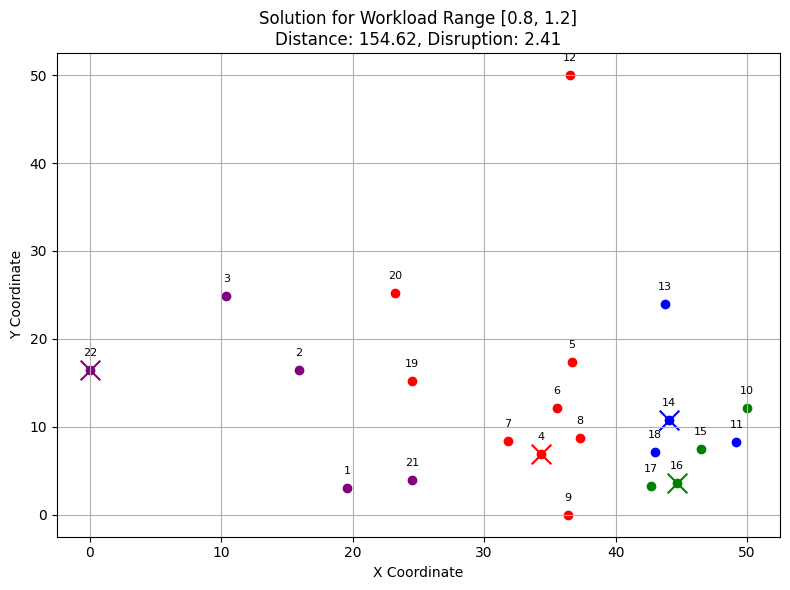

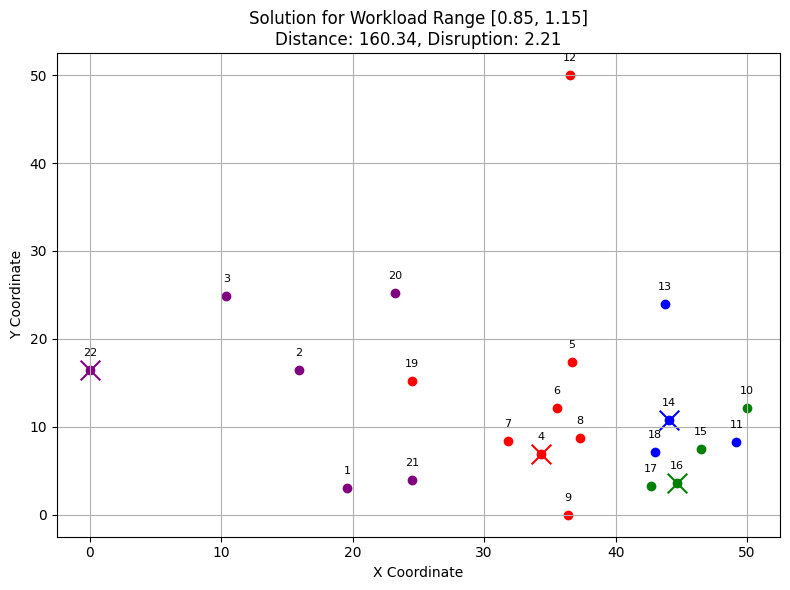

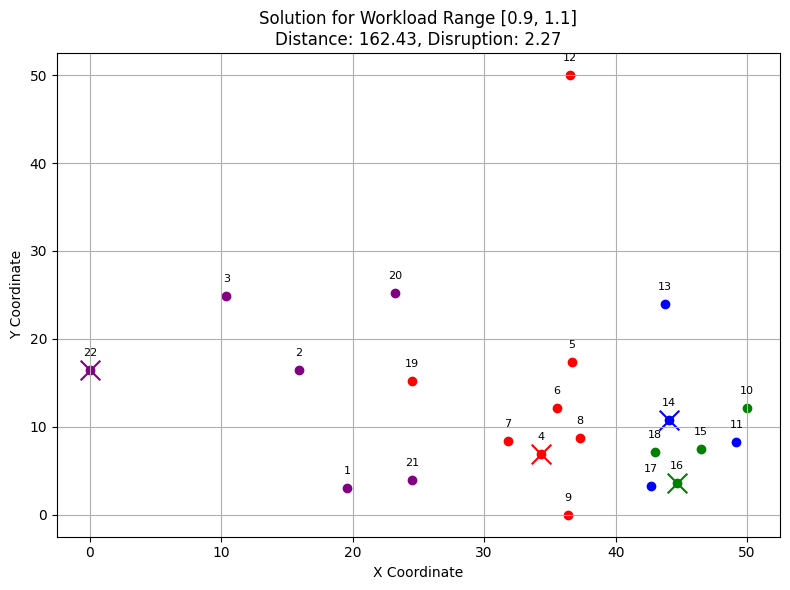

In [47]:
import matplotlib.pyplot as plt
import numpy as np

# Peut etre amélioré 
coordinates = [
    [19.59, 3.08], [15.90, 16.49], [10.39, 24.89], [34.29, 6.87], [36.68, 17.34], [35.51, 12.13], [31.80, 8.40], [37.27, 8.72], [36.39, 0.00], 
    [50.00, 12.13], [49.18, 8.30], [36.51, 50.00], [43.75, 23.99], [44.06, 10.83], [46.51, 7.46], [44.68, 3.59], [42.68, 3.27], [43.02, 7.13], 
    [24.51, 15.21], [23.24, 25.21], [24.51, 3.94], [0.00, 16.49]
]
x_vals, y_vals = zip(*coordinates)

sr_colors = ['red', 'blue', 'green', 'purple']

# Function to plot a single solution on the map
def plot_solution_on_map(solution, workload_range, sr_colors):
    L, U, distance, disruption, assignment = solution
    plt.figure(figsize=(8, 6))
    
    # Plot each brick with its assigned SR color
    for brick_idx, sr_idx in enumerate(np.argmax(assignment, axis=0)):
        x, y = coordinates[brick_idx]
        plt.scatter(x, y, color=sr_colors[sr_idx], label=f'SR {sr_idx + 1}' if brick_idx == 0 else "")
        
        # Add the brick number as text next to the brick
        plt.annotate(f"{brick_idx + 1}", (x, y), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8)
    
    # Plot the SR offices (center bricks)
    center_bricks = [4, 14, 16, 22]  # Center bricks for SRs
    for sr_idx, center_brick in enumerate(center_bricks):
        x, y = coordinates[center_brick - 1]  # Adjust for 0-based index
        plt.scatter(x, y, color=sr_colors[sr_idx], marker='x', s=200, edgecolor='black', label=f'SR {sr_idx + 1} Office' if sr_idx == 0 else "")
    
    plt.title(f"Solution for Workload Range {workload_range}\nDistance: {distance:.2f}, Disruption: {disruption:.2f}")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(True)
    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

# Plot one solution for each workload range
for workload_range in workload_bounds:
    # Find the first solution for the current workload range
    solution = next((sol for sol in pareto_solutions if (sol[0], sol[1]) == workload_range), None)
    if solution:
        plot_solution_on_map(solution, f"[{workload_range[0]}, {workload_range[1]}]", sr_colors)
    else:
        print(f"No solution found for workload range {workload_range}")

/var/folders/mq/p11ms59j2wb4jv8z4lwk2m8m0000gn/T/ipykernel_10797/2801828122.py:31: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(x, y, color=sr_colors[sr_idx], marker='x', s=200, edgecolor='black', label=f'SR {sr_idx + 1} Office' if sr_idx == 0 else "")


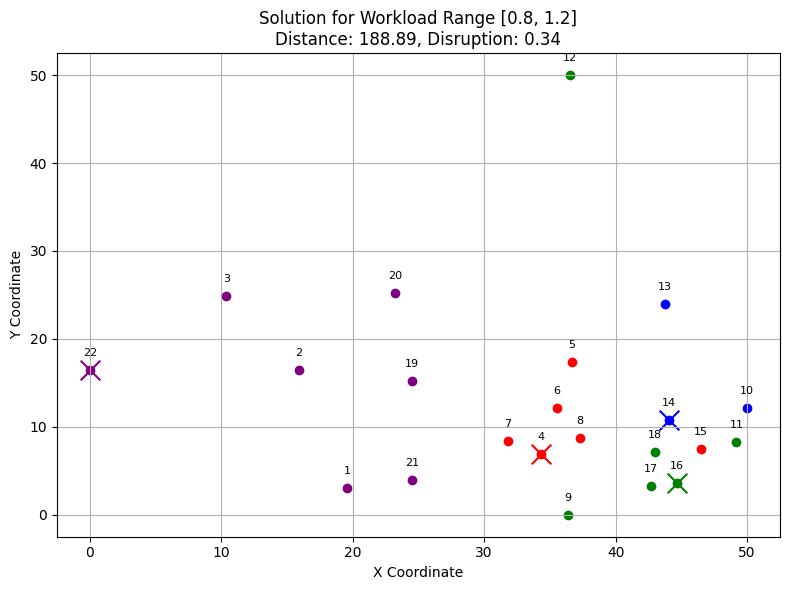

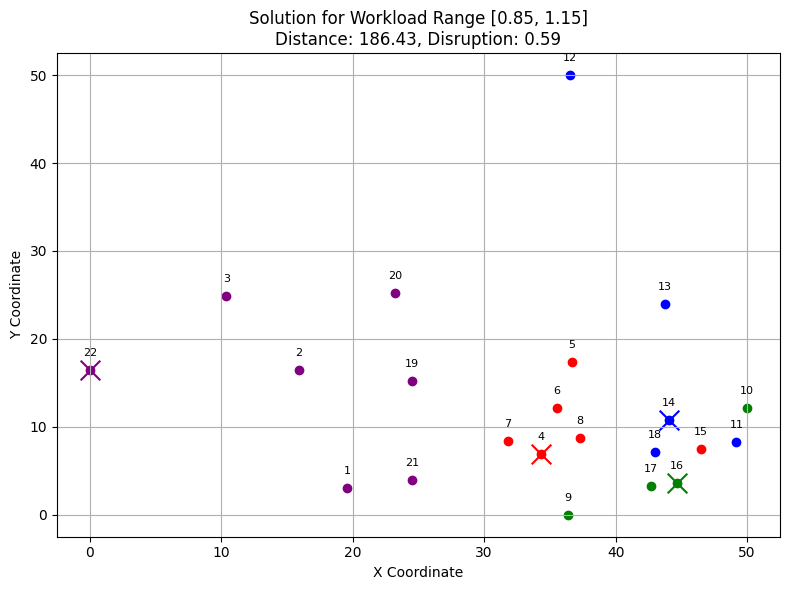

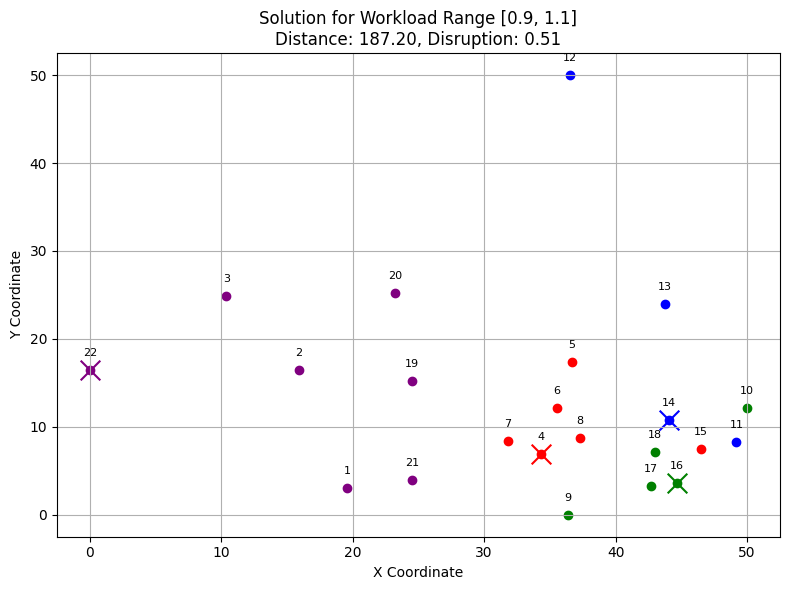

In [48]:
for workload_range in workload_bounds:
    # Find all solutions for the current workload range
    solutions_for_range = [sol for sol in pareto_solutions if (sol[0], sol[1]) == workload_range]
    
    if solutions_for_range:
        # Select the last solution in the list (last Pareto solution for this range)
        last_solution = solutions_for_range[-1]
        plot_solution_on_map(last_solution, f"[{workload_range[0]}, {workload_range[1]}]", sr_colors)
    else:
        print(f"No solution found for workload range {workload_range}")

# STEP 2

### Test Instance 10-100

In [11]:
# chargement des données du problème à 10 SR et 100 zones
import pandas as pd

df = pd.read_csv("./Pfitzer10-100.csv", sep=";", decimal=",")

df.columns = [
    "zone",
    "x",
    "y",
    "workload_index",
    "current_office",
    "rp1",
    "rp2",
    "rp3",
    "rp4",
    "rp5",
    "rp6",
    "rp7",
    "rp8",
    "rp9",
    "rp10",
]

# Position centrale des zones
position_bricks100 = np.array(
    [df.loc[brick - 1, ["x", "y"]].values.tolist() for brick in range(1, 101)]
)


# Création de d100
def calcul_distance(pos1: list, pos2: list) -> float:
    """
    Calcule et renvoie la distance euclidienne entre deux positions.
    """
    return ((pos1[0] - pos2[0]) ** 2 + (pos1[1] - pos2[1]) ** 2) ** (1 / 2)


position_srs = []
for i in range(1, 11):
    position_srs.append(
        df.loc[
            (df["current_office"] == 1) & (df[f"rp{i}"] == 1), ["x", "y"]
        ].values.tolist()[0]
    )
d100 = np.zeros(shape=(10, 100))
for brick in range(1, 101):
    for sr in range(0, 10):
        position_brick = position_bricks100[brick - 1]
        d100[sr, brick - 1] = calcul_distance(position_brick, position_srs[sr])

# Création de P100
assignment_matrix_10sr_100b = np.zeros(shape=(10, 100))
for sr_id in range(1, 11):
    indices = df[df[f"rp{sr_id}"] == 1].index
    assignment_matrix_10sr_100b[sr_id - 1, indices - 1] = 1


# Création de w100
workload_matrix_10sr_100b = df["workload_index"].to_list()

# Distance entre les centres de bricks
distances_matrix_10sr_100b = np.zeros((100, 100))
for i in range(100):
    for j in range(i + 1, 100):
        distances_matrix_10sr_100b[i, j] = calcul_distance(
            position_bricks100[i], position_bricks100[j]
        )
        distances_matrix_10sr_100b[j, i] = distances_matrix_10sr_100b[i, j]

In [12]:
# import pandas as pd
# import numpy as np

# # Chargement du fichier CSV
# file_path = "./Pfitzer10-100.csv"
# df = pd.read_csv(file_path, sep=";", decimal=",")

# # Renommage des colonnes
# df.columns = ["zone", "x", "y", "workload_index", "current_office"] + [
#     f"rp{i}" for i in range(1, 11)
# ]

# # Assurer que les zones sont des entiers
# df["zone"] = df["zone"].astype(int)

# # Position centrale des zones (bricks)
# position_bricks100 = np.array(df[["x", "y"]].values)


# # Fonction pour calculer la distance euclidienne
# def calcul_distance(pos1: list, pos2: list) -> float:
#     return np.sqrt((pos1[0] - pos2[0]) ** 2 + (pos1[1] - pos2[1]) ** 2)


# # Détermination des positions des représentants (SRs) en fonction de leur bureau actuel
# position_srs = []
# for i in range(1, 11):
#     sr_positions = df.loc[
#         (df["current_office"] == 1) & (df[f"rp{i}"] == 1), ["x", "y"]
#     ].values
#     if sr_positions.size > 0:
#         position_srs.append(sr_positions[0])  # Prendre la première position trouvée
#     else:
#         position_srs.append([0, 0])  # Valeur par défaut si aucun bureau n'est trouvé

# # Création de la matrice des distances d100 (entre SRs et zones)
# distances_matrix_10sr_100b = np.zeros((10, 100))
# for brick in range(100):
#     for sr in range(10):
#         d100[sr, brick] = calcul_distance(position_bricks100[brick], position_srs[sr])

# # Création de la matrice d'assignation initiale P100 sans erreur de décalage
# assignment_matrix_10sr_100b = np.zeros((10, 100), dtype=int)
# for sr_id in range(1, 11):
#     assigned_zones = df.loc[df[f"rp{sr_id}"] == 1, "zone"].values.astype(int)
#     for zone in assigned_zones:
#         if 1 <= zone <= 100:
#             assignment_matrix_10sr_100b[sr_id - 1, zone - 1] = 1

# # Création de la matrice des charges de travail w100
# workload_matrix_10sr_100b = df["workload_index"].to_numpy()

# # Création de la matrice des distances entre les centres des zones
# distance_between_bricks100 = np.zeros((100, 100))
# for i in range(100):
#     for j in range(i + 1, 100):
#         distance_between_bricks100[i, j] = calcul_distance(
#             position_bricks100[i], position_bricks100[j]
#         )
#         distance_between_bricks100[j, i] = distance_between_bricks100[i, j]


Solving for workload constraints: [0.8, 1.2]
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 23.6.0 23G80)

CPU model: Apple M3
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 120 rows, 1000 columns and 3000 nonzeros
Model fingerprint: 0x46336b94
Model has 1000 quadratic objective terms
Variable types: 0 continuous, 1000 integer (1000 binary)
Coefficient statistics:
  Matrix range     [1e-03, 1e+00]
  Objective range  [2e-03, 4e-01]
  QObjective range [2e-03, 4e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [8e-01, 1e+00]
Found heuristic solution: objective 18.1354000
Presolve time: 0.00s
Presolved: 120 rows, 1000 columns, 3000 nonzeros
Variable types: 0 continuous, 1000 integer (1000 binary)

Root relaxation: objective 2.000020e+01, 206 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    B

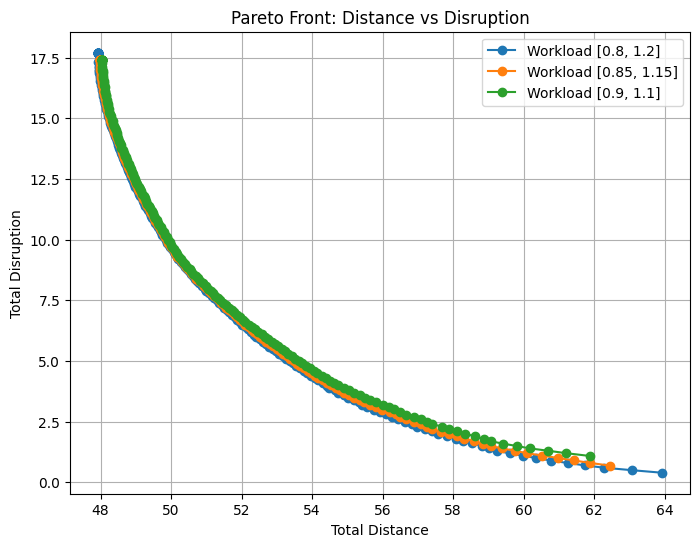

In [13]:
pareto_solutions_10sr_100b = epsilon_constraint_scheme(assignment_matrix_10sr_100b, distances_matrix_10sr_100b, workload_matrix_10sr_100b, workload_bounds)
plot_pareto_solutions(pareto_solutions_10sr_100b)

### Plusieurs SRs pour une même brique

### +25% Workload et ajout d'un SR